#### Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import re
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

#### loading and displaying the datasets

In [2]:

train_data = pd.read_csv('SQLIV3_cleaned2.csv')
test_data = pd.read_csv('sqliv2_utf8.csv')
print(train_data)

                                                Sentence  Label
0                      " or pg_sleep  (  __TIME__  )  --      1
1      create user name identified by pass123 tempora...      1
2       AND 1  =  utl_inaddr.get_host_address   (    ...      1
3       select * from users where id  =  '1' or @ @1 ...      1
4       select * from users where id  =  1 or 1#"  ( ...      1
...                                                  ...    ...
30609              DELETE FROM door WHERE grow = 'small'      0
30610                               DELETE FROM tomorrow      0
30611                       SELECT wide ( s )  FROM west      0
30612       SELECT * FROM  ( SELECT slide FROM breath )       0
30613                           SELECT TOP 3 * FROM race      0

[30614 rows x 2 columns]


In [3]:
train_data.duplicated().sum()

12

#### Remove duplicates from train and test sets.


In [4]:

train_data.drop_duplicates(subset='Sentence', keep='first', inplace=True)
test_data.drop_duplicates(subset='Sentence', keep='first', inplace=True)


In [5]:
train_data.duplicated().sum()

0

#### 'Label' Data Distribution


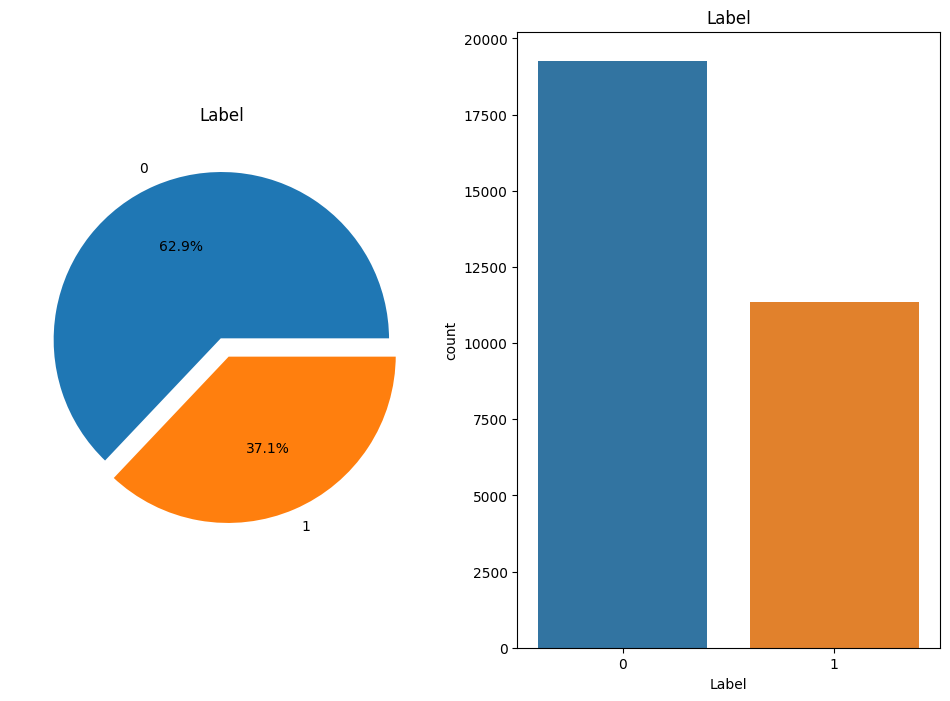

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
train_data['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=train_data, ax=ax[1], palette=colors)
ax[1].set_title('Label')
plt.show()

In [7]:
train_data

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30609,DELETE FROM door WHERE grow = 'small',0
30610,DELETE FROM tomorrow,0
30611,SELECT wide ( s ) FROM west,0
30612,SELECT * FROM ( SELECT slide FROM breath ),0


#### Tokenization (keeping all characters)


In [ ]:

vocab_size = 15000
tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token="<OOV>",
    filters='',
    lower=True
)
tokenizer.fit_on_texts(train_data['Sentence'])


#### Adaptive Padding

In [11]:

max_len = int(np.percentile([len(x.split()) for x in train_data['Sentence']], 95))
X = tokenizer.texts_to_sequences(train_data['Sentence'])
X = pad_sequences(X, padding='post', maxlen=max_len)
y = train_data['Label'].astype('int')


#### Train/Validation Split


In [12]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=34,shuffle=True)



#### Model Architecture

In [13]:

embedding_dim = 128
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),

    LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),

    LSTM(128, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Model Compilation with Early Stopping and Adam Optimizer


In [14]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


#### Model Training

In [15]:

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8463 - loss: 0.8560 - val_accuracy: 0.9926 - val_loss: 0.3503
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9936 - loss: 0.3078 - val_accuracy: 0.9940 - val_loss: 0.2176
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9941 - loss: 0.2006 - val_accuracy: 0.9953 - val_loss: 0.1540
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9912 - loss: 0.1636 - val_accuracy: 0.9858 - val_loss: 0.1692
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9904 - loss: 0.1478 - val_accuracy: 0.9920 - val_loss: 0.1305
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9932 - loss: 0.1232 - val_accuracy: 0.9925 - val_loss: 0.1188
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9935 - loss: 0.1124 - val_accuracy: 0.9925 - val_loss: 0.1110
Epoch 8/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9935 - loss: 0.1057 - val_ac

In [16]:
print("Final Training Loss:", history.history['loss'][-1])
print("Final Training Accuracy:", history.history['accuracy'][-1])

Final Training Loss: 0.03610701113939285
Final Training Accuracy: 0.998733639717102


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.9962418300653595
Precision: 0.9973345179920036
Recall: 0.9925
F1 Score: 0.9949

Classification Report:
                precision    recall  f1-score   support

Non-injection       1.00      1.00      1.00      3858
    Injection       1.00      0.99      0.99      2262

     accuracy                           1.00      6120
    macro avg       1.00      1.00      1.00      6120
 weighted avg       1.00      1.00      1.00      6120



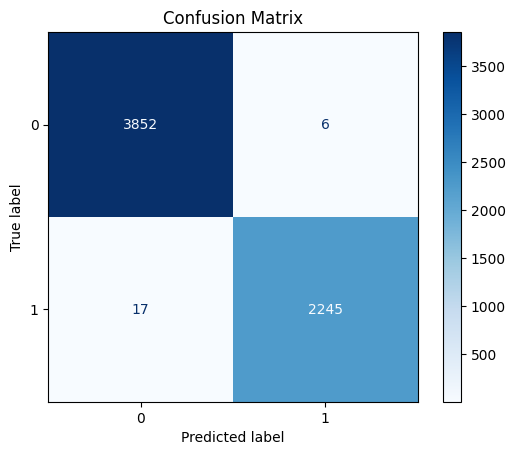

In [ ]:


y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype("int32")


accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=['Non-injection', 'Injection']))


conf_matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

#### Plotting Loss and Accuracy over Epochs


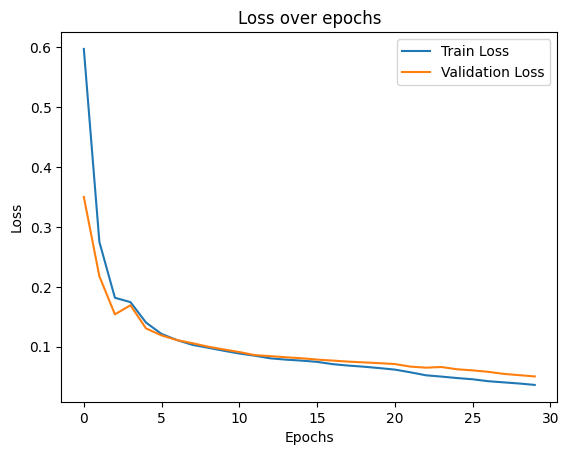

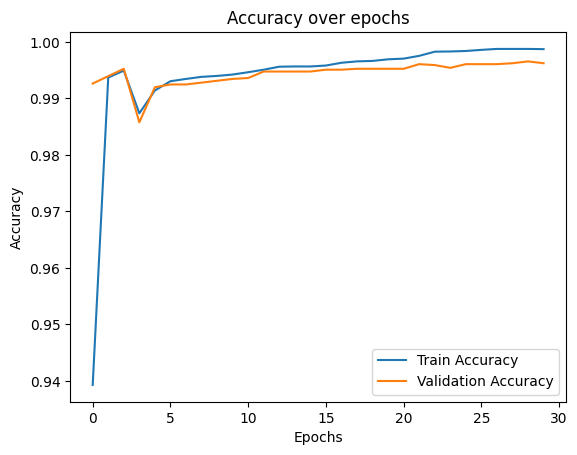

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Filter Only SQL Injection (Label = 1)


In [40]:

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

sqli_only = test_data[test_data['Label'] == 1].copy()
print(f"\n total number of SQL injection in the dataset : {len(sqli_only)}")







 total number of SQL injection in the dataset : 11424


#### Preprocessing SQL Injection Sentences


In [20]:

X_sqli = tokenizer.texts_to_sequences(sqli_only['Sentence'])
X_sqli = pad_sequences(X_sqli, padding='post', maxlen=max_len)
y_sqli_true = np.ones(len(sqli_only))

#### Prediction and Metrics Evaluation


In [21]:

sqli_preds = model.predict(X_sqli)
sqli_preds_labels = (sqli_preds > 0.5).astype(int)

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [22]:

true_positives = np.sum(sqli_preds_labels == 1)
detection_rate = (true_positives / len(sqli_only)) * 100
accuracy = accuracy_score(y_sqli_true, sqli_preds_labels)
precision = precision_score(y_sqli_true, sqli_preds_labels)
recall = recall_score(y_sqli_true, sqli_preds_labels)
f1 = f1_score(y_sqli_true, sqli_preds_labels)

In [33]:

print(f"\n Injections correctly detected : {true_positives}")
print(f" Taux de détection : {detection_rate:.2f}%")
print(f"\n Evaluation on SQL injection (Label = 1) :")
print(f" Accuracy  : {accuracy * 100:.2f}%")
print(f" Precision : {precision * 100:.2f}%")
print(f" Recall    : {recall * 100:.2f}%")
print(f" F1 Score  : {f1 * 100:.2f}%")



 Injections correctly detected : 11359
 Taux de détection : 99.43%

 Evaluation on SQL injection (Label = 1) :
 Accuracy  : 99.62%
 Precision : 99.73%
 Recall    : 99.25%
 F1 Score  : 99.49%


#### Filter Only Normal Queries (Label = 0)


In [ ]:
normal_only = test_data[test_data['Label'] == 0].copy()
print(f"\n total number of normal query in the dataset : {len(normal_only)}")


 total number of normal query in the dataset : 22302


#### Preprocessing Normal Queries Sentences


In [37]:
normal_only['Sentence'] = normal_only['Sentence'].astype(str)
X_normal = tokenizer.texts_to_sequences(normal_only['Sentence'])
X_normal = pad_sequences(X_normal, padding='post', maxlen=max_len)
y_normal_true = np.zeros(len(normal_only))

#### Prediction and Metrics Evaluation


In [38]:

normal_preds = model.predict(X_normal)
normal_preds_labels = (normal_preds > 0.5).astype(int)

697/697 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [39]:

print("\n Evaluation on normal query (Label = 0):")
print(f" Accuracy : {accuracy_score(y_normal_true, normal_preds_labels) * 100:.2f}%")
print(f" Precision : {precision_score(y_normal_true, normal_preds_labels, pos_label=0, zero_division=0) * 100:.2f}%")
print(f" Recall : {recall_score(y_normal_true, normal_preds_labels, pos_label=0, zero_division=0) * 100:.2f}%")
print(f" F1 Score : {f1_score(y_normal_true, normal_preds_labels, pos_label=0, zero_division=0) * 100:.2f}%")



 Evaluation on normal query (Label = 0):
 Accuracy : 99.47%
 Precision : 100.00%
 Recall : 99.47%
 F1 Score : 99.73%


In [41]:
model.save('/content/lstm.h5')
